# Lending Club - Loan Repayment Prediction
## Interim Results Report

This report consists of two main parts:

Part 1:
    Cleaning and preparing the data set
    
Part 2:
    Creating models, making predictions and measuring results.
   
    
Part 2 consists of 3 sub-sections:
    1. Random Forest model, predictions and performance measurements
    2. Bagged Decision Trees model, predictions and performance measurements
    3. Bagged Neural Networks model, predictions and performance measurements

#### Loading Raw Data

In [50]:
lending_club_2012_2013 <- read.csv("lending_club_rfe/LoanStats3b_securev1.csv", header=TRUE)
lending_club_2007_2011 <- read.csv("lending_club_rfe/LoanStats3a_securev1.csv", header=TRUE)

#### Pruning data set to include only 36 month term loans issued up to February 2013
The reason for this is because all 36 month loans issued February 2013 or earlier have fully come to term.

In [51]:
lending_club_jan_2013 <- subset(lending_club_2012_2013,issue_d == "Jan-2013")
lending_club_feb_2013 <- subset(lending_club_2012_2013,issue_d == "Feb-2013")
lending_club_2012 <- subset(lending_club_2012_2013,grepl("2012",issue_d))
lending_club_final <- rbind(lending_club_jan_2013,lending_club_feb_2013,lending_club_2012,lending_club_2007_2011)
lending_club_final <- subset(lending_club_final,grepl("36",term))

#### Adding label (default_status) to the data set
default_status:

1 = true (default has occured)

0 = false (default has not occured)

In [52]:
status <- c("Current","Fully Paid","Late (16-30 days)","Does not meet the credit policy. Status:Charged Off","Charged Off","Default","In Grace Period","Late (31-120 days)","Does not meet the credit policy. Status:Fully Paid")
default_status <- c(0,0,1,1,1,1,1,1,0)
lending_club_default <- data.frame(default = default_status[match(lending_club_final$loan_status, status)])
lending_club_final <- cbind(lending_club_final,lending_club_default)

#### Eliminate features which are mostly NA

In [53]:
na_pct <-sapply(lending_club_final, function(y) sum(is.na(y))/length(y))
na_pct <- data.frame(na_pct)
mostly_na <- na_pct > 0.2

lending_club_final <- lending_club_final[,mostly_na==FALSE] 

#### Cleaning data - Little touch-ups

In [54]:
# convert issue_d to dates because as factors they have too many levels!
lending_club_final$issue_d <- as.vector(sapply(lending_club_final$issue_d, function(x) paste0(x,"-01")))
lending_club_final$issue_d <- as.Date(lending_club_final$issue_d,"%b-%Y-%d")

# convert int_rate to numeric
lending_club_final$int_rate <- as.character(lending_club_final$int_rate)
lending_club_final$int_rate <- as.numeric(substr(lending_club_final$int_rate,1,nchar(lending_club_final$int_rate)-1))
 
# convert earliest_cr_line to date
lending_club_final$earliest_cr_line <- as.character(lending_club_final$earliest_cr_line)
lending_club_final$earliest_cr_line <- as.vector(sapply(lending_club_final$earliest_cr_line, function(x) paste0(x,"-01")))
lending_club_final$earliest_cr_line <- as.Date(lending_club_final$earliest_cr_line,"%b-%Y-%d")

# convert revol_util to numeric
lending_club_final$revol_util <- as.character(lending_club_final$revol_util)
lending_club_final$revol_util <- as.numeric(substr(lending_club_final$revol_util,1,nchar(lending_club_final$revol_util)-1))

# convert last_credit_pull_d to dates because as factors they have too many levels!
lending_club_final$last_credit_pull_d <- as.character(lending_club_final$last_credit_pull_d)
lending_club_final$last_credit_pull_d <- as.vector(sapply(lending_club_final$last_credit_pull_d, function(x) paste0(x,"-01")))
lending_club_final$last_credit_pull_d <- as.Date(lending_club_final$last_credit_pull_d,"%b-%Y-%d")
    
# convert zip_code to char because as a factor it has too many levels
#lending_club_final$zip_code <- as.character(lending_club_final$zip_code)
    
# remove useless variables
to_remove <- c("url","desc","title","emp_title","id","loan_status","zip_code")
lending_club_final <- lending_club_final[ , !(names(lending_club_final) %in% to_remove)]


#### Remove incomplete records
Incomplete records should be removed as long as they are a small portion of the data set < 3%

In [55]:
nrows <- nrow(lending_club_final)
ncomplete <- sum(complete.cases(lending_club_final))
print(1-(ncomplete/nrows))

[1] 0.01697246


Since incomplete rows represent < 3% of data set, remove them. 

In [56]:
lending_club_final <- lending_club_final[complete.cases(lending_club_final),]

# how many records in data set so far
lcf_before_na_rm <- nrow(lending_club_final)
lcf_before_na_rm

[1] 85083

#### Check for records with NA's

In [57]:
sapply(lending_club_final, function(x) sum(is.na(x)))

member_id                  loan_amnt 
                         0                          0 
               funded_amnt            funded_amnt_inv 
                         0                          0 
                      term                   int_rate 
                         0                          0 
               installment                      grade 
                         0                          0 
                 sub_grade                 emp_length 
                         0                          0 
            home_ownership                 annual_inc 
                         0                          0 
       verification_status                    issue_d 
                         0                          0 
                pymnt_plan                    purpose 
                         0                          0 
                addr_state                        dti 
                         0                          0 
               delinq_2yrs           earliest_cr_line 
                         0                          0 
            fico_range_low            fico_range_high 
                         0                          0 
            inq_last_6mths                   open_acc 
                         0                          0 
                   pub_rec                  revol_bal 
                         0                          0 
                revol_util                  total_acc 
                         0                          0 
       initial_list_status                  out_prncp 
                         0                          0 
             out_prncp_inv                total_pymnt 
                         0                          0 
           total_pymnt_inv            total_rec_prncp 
                         0                          0 
             total_rec_int         total_rec_late_fee 
                         0                          0 
                recoveries    collection_recovery_fee 
                         0                          0 
              last_pymnt_d            last_pymnt_amnt 
                         0                          0 
              next_pymnt_d         last_credit_pull_d 
                         0                          0 
      last_fico_range_high        last_fico_range_low 
                         0                          0 
collections_12_mths_ex_med                policy_code 
                         0                          0 
          application_type             acc_now_delinq 
                         0                          0 
  chargeoff_within_12_mths                delinq_amnt 
                         0                          0 
      pub_rec_bankruptcies                  tax_liens 
                         0                          0 
                   default 
                         0

#### Cleaning data set and removing variables/features not known at issuance of loan
I am removing all variables which are not known at the time of issuance because the aim of this project is to determine a predictive model which can be used before issuing a loan.

In [58]:
lending_club_final <- lending_club_final[, !(colnames(lending_club_final) %in% c("total_rec_int","total_pymnt_inv","total_pymnt"
                                                                                 ,"total_rec_prncp","collection_recovery_fee",
                                                                                 "recoveries","last_pymnt_amnt",
                                                                                 "total_rec_late_fee","last_pymnt_d",
                                                                                 "last_pymnt_amnt","next_pymnt_d"))]

#### Makeup of the data set after cleansing and pruning

In [59]:
str(lending_club_final)

'data.frame':	85083 obs. of  43 variables:
 $ member_id                 : int  4068919 3982350 4058105 4067567 4057467 3982347 4067275 3417777 4066823 4027605 ...
 $ loan_amnt                 : int  22000 4750 2000 5000 2500 1800 4500 6000 4200 3600 ...
 $ funded_amnt               : int  22000 4750 2000 5000 2500 1800 4500 6000 4200 3600 ...
 $ funded_amnt_inv           : num  22000 4750 2000 5000 2500 1800 4500 6000 4200 3600 ...
 $ term                      : Factor w/ 3 levels ""," 36 months",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ int_rate                  : num  17.3 19.1 19.7 19.1 21.5 ...
 $ installment               : num  787.3 174.2 74 183.4 94.8 ...
 $ grade                     : Factor w/ 8 levels "","A","B","C",..: 4 5 5 5 6 5 4 4 4 5 ...
 $ sub_grade                 : Factor w/ 36 levels "","A1","A2","A3",..: 16 20 21 20 24 18 13 13 16 17 ...
 $ emp_length                : Factor w/ 13 levels "","< 1 year",..: 4 7 4 4 10 4 4 4 10 4 ...
 $ home_ownership            : Factor w/ 6 l

#### Create training and test data sets

In [60]:
train_rows <- sample(nrow(lending_club_final),20000)
lending_club.train <- lending_club_final[train_rows,]
lending_club.test <- lending_club_final[-train_rows,]

### Random Forest
#### Train model - Pre-RFE
I am training the random forest algorithm against all of the variables/features because I want to create an Importance Plot (see next step) and use it as a comparison to the RFE analysis.

In [61]:
library(randomForest)
set.seed(9)

rf.fit <- randomForest(as.factor(default)~., data=lending_club.train, importance=TRUE, ntree=700)

#### Plot the importance of each of the variables (at least the significantly important ones)

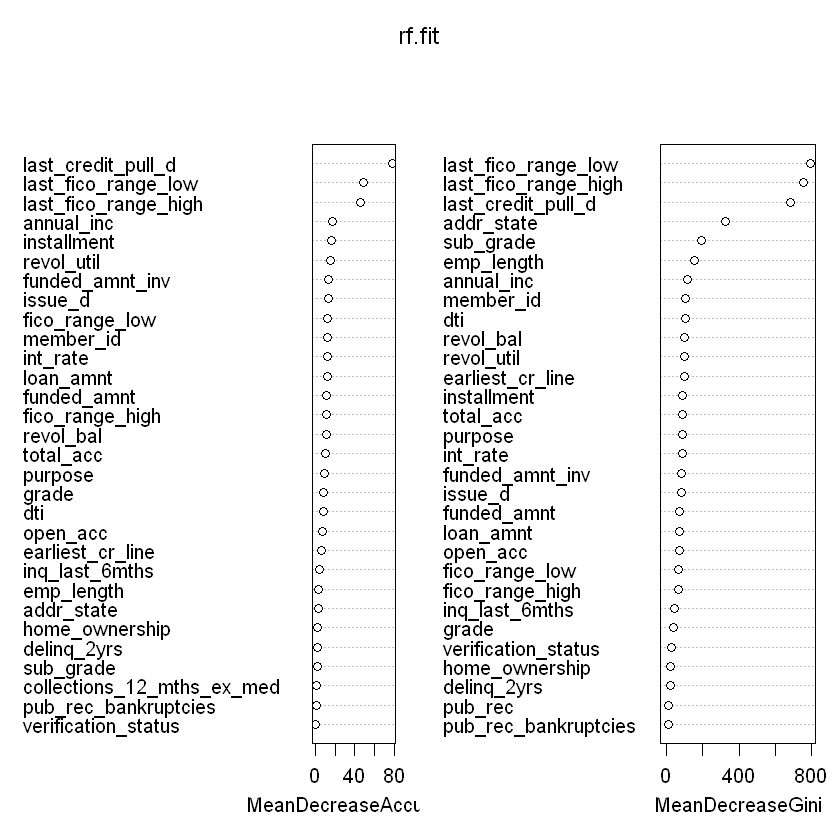

In [62]:
varImpPlot(rf.fit)

#### Generate predictions (Random Forest - Pre-RFE)

In [64]:
library(caret)
install.packages("e1071", repos='http://cran.us.r-project.org',dependencies = TRUE)
library(e1071)

# Generate predictions based on model
lending_club.test$default.pred <- predict(rf.fit,lending_club.test)

Warning message:
"package 'e1071' is in use and will not be installed"

#### Measure performance - Random Forest Pre-RFE

In [67]:
# Create Confusion Matrix
confusionMatrix(lending_club.test$default.pred,lending_club.test$default)

install.packages("pROC", repos='http://cran.us.r-project.org',dependencies = TRUE)
library(pROC)
# area under a ROC curve
auc(lending_club.test$default,as.numeric(lending_club.test$default.pred))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 56693  7748
         1   107   535
                                          
               Accuracy : 0.8793          
                 95% CI : (0.8768, 0.8818)
    No Information Rate : 0.8727          
    P-Value [Acc > NIR] : 2.048e-07       
                                          
                  Kappa : 0.1035          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.99812         
            Specificity : 0.06459         
         Pos Pred Value : 0.87977         
         Neg Pred Value : 0.83333         
             Prevalence : 0.87273         
         Detection Rate : 0.87109         
   Detection Prevalence : 0.99014         
      Balanced Accuracy : 0.53135         
                                          
       'Positive' Class : 0               
                                          

also installing the dependencies 'misc3d', 'rgl', 'multicool', 'ks', 'microbenchmark', 'logcondens', 'doParallel'



package 'misc3d' successfully unpacked and MD5 sums checked
package 'rgl' successfully unpacked and MD5 sums checked
package 'multicool' successfully unpacked and MD5 sums checked
package 'ks' successfully unpacked and MD5 sums checked
package 'microbenchmark' successfully unpacked and MD5 sums checked
package 'logcondens' successfully unpacked and MD5 sums checked
package 'doParallel' successfully unpacked and MD5 sums checked
package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ethan\AppData\Local\Temp\Rtmp6ZpgeQ\downloaded_packages


Warning message:
"package 'pROC' was built under R version 3.3.2"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



Area under the curve: 0.5314

#### Recursive Feature Elimination (RFE)
So far we have not considered significance when cleansing the data set.  RFE analysis will identify a data set subset for optimal results.

In [72]:
# Let's use RFE to see if we can prune some variables/features and hopefully get a better result
set.seed(123)
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
lending_club.train.rfe <- lending_club.train[sample(nrow(lending_club.train),2000),]
rfe.train <- rfe(lending_club.train.rfe[,1:42], lending_club.train.rfe[,43], sizes=1:42, rfeControl=control)

# how big is the optimal variable subset?
print(rfe.train$bestSubset)

Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y, importance = first, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(

[1] 3


#### Plot the number of variables vs. RMSE

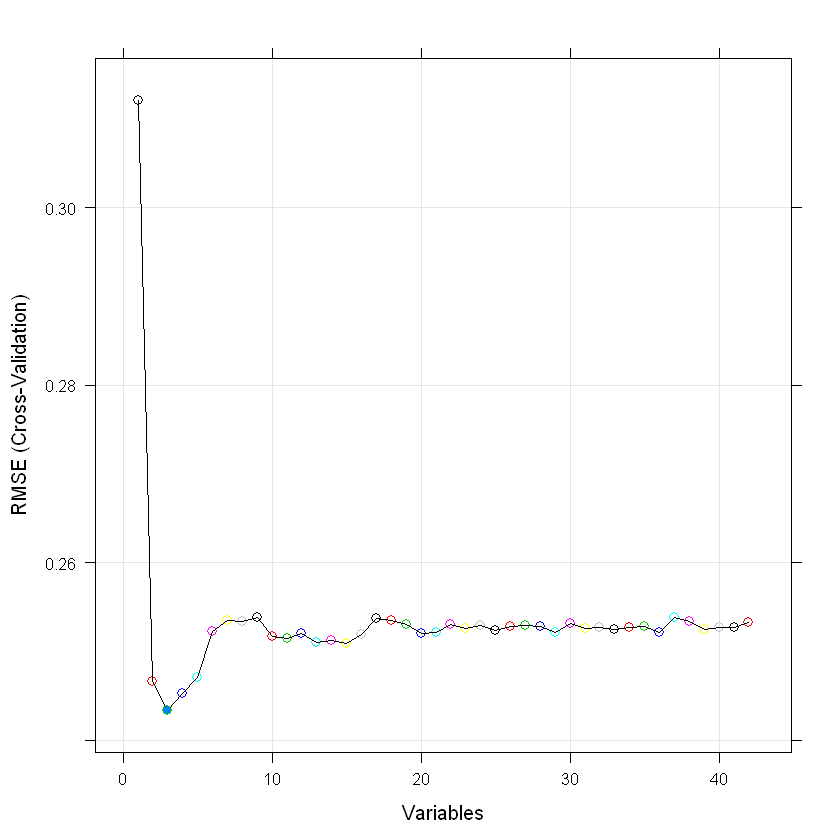

In [73]:
plot(rfe.train, type=c("g", "o"), cex = 1.0, col = 1:43)

#### What specific variables/features comprise the optimal subset?

In [74]:
predictors(rfe.train)

[1] "last_credit_pull_d"   "last_fico_range_low"  "last_fico_range_high"

#### Train Random Forest model Post-RFE and generate predictions

In [75]:
# According to RFE the optimal subset of variables is "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low" 
# Redo the Random Forest model with the optimal subset according to RFE
set.seed(44)
rf.fit.opt <- randomForest(as.factor(default)~last_credit_pull_d+last_fico_range_high+last_fico_range_low, 
                                                              data=lending_club.train, ntree=1000, type='classification')

lending_club.test$default.pred.opt <- predict(rf.fit.opt,lending_club.test)

#### Measure performance - Random Forest Post-RFE

In [76]:
# Create Confusion Matrix
confusionMatrix(lending_club.test$default.pred.opt,lending_club.test$default)

# find area under a ROC curve
auc(lending_club.test$default,as.numeric(lending_club.test$default.pred.opt))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 53876  2076
         1  2924  6207
                                          
               Accuracy : 0.9232          
                 95% CI : (0.9211, 0.9252)
    No Information Rate : 0.8727          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6687          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9485          
            Specificity : 0.7494          
         Pos Pred Value : 0.9629          
         Neg Pred Value : 0.6798          
             Prevalence : 0.8727          
         Detection Rate : 0.8278          
   Detection Prevalence : 0.8597          
      Balanced Accuracy : 0.8489          
                                          
       'Positive' Class : 0               
                                          

Area under the curve: 0.8489

#### Train Random Forest model Post-RFE (increase nodesize) and generate predictions
By increasing the nodesize, the number of nodes will decrease, thus simplifying the decision trees.

In [77]:
# redo with larger nodesize - should make tree simpler
rf.fit.opt2 <- randomForest(as.factor(default)~last_credit_pull_d+last_fico_range_high+last_fico_range_low, 
                           data=lending_club.train, ntree=1000, type='classification', nodesize=800)

lending_club.test$default.pred.opt2 <- predict(rf.fit.opt2,lending_club.test)

#### Measure performance - Random Forest Post-RFE (increased nodesize)

In [78]:
# Create Confusion Matrix
confusionMatrix(lending_club.test$default.pred.opt2,lending_club.test$default)

# find Area Under a ROC Curve (AUC)
auc(lending_club.test$default,as.numeric(lending_club.test$default.pred.opt2))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 53906  2117
         1  2894  6166
                                         
               Accuracy : 0.923          
                 95% CI : (0.9209, 0.925)
    No Information Rate : 0.8727         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6668         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9490         
            Specificity : 0.7444         
         Pos Pred Value : 0.9622         
         Neg Pred Value : 0.6806         
             Prevalence : 0.8727         
         Detection Rate : 0.8283         
   Detection Prevalence : 0.8608         
      Balanced Accuracy : 0.8467         
                                         
       'Positive' Class : 0              
                                         

Area under the curve: 0.8467

### Bagged Decision Trees 
#### Create model and make predictions

In [80]:
# BAGGED DECISION TREES
library(rpart)
install.packages("adabag", repos='http://cran.us.r-project.org',dependencies = TRUE)
library(adabag)
lending_club.train$default.factor <- as.factor(lending_club.train$default)
lending_club.test$default.factor <- as.factor(lending_club.test$default)

# mfinal indicates total number of trees grown 
# and minsplit is the minimum number of observations that must exist in a node in order for a split to be attempted
bdt.bagging <- bagging(default.factor~last_credit_pull_d+last_fico_range_high+last_fico_range_low, 
                            data=lending_club.train, mfinal=1000, control=rpart.control(minsplit = 800))

# make predictions
bdt.bagging.pred <- predict.bagging(bdt.bagging, newdata=lending_club.test)

package 'adabag' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ethan\AppData\Local\Temp\Rtmp6ZpgeQ\downloaded_packages


Warning message:
"package 'adabag' was built under R version 3.3.2"Loading required package: mlbench


#### Measure performance - Bagged Decision Trees

In [81]:
# Create Confusion Matrix
confusionMatrix(bdt.bagging.pred$class,lending_club.test$default)

# find Area Under a ROC Curve (AUC)
auc(lending_club.test$default,as.numeric(bdt.bagging.pred$class))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 53667  1882
         1  3133  6401
                                         
               Accuracy : 0.9229         
                 95% CI : (0.9209, 0.925)
    No Information Rate : 0.8727         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6741         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9448         
            Specificity : 0.7728         
         Pos Pred Value : 0.9661         
         Neg Pred Value : 0.6714         
             Prevalence : 0.8727         
         Detection Rate : 0.8246         
   Detection Prevalence : 0.8535         
      Balanced Accuracy : 0.8588         
                                         
       'Positive' Class : 0              
                                         

Area under the curve: 0.8588

### Bagged Neural Networks

In [83]:
library(nnet)

lending_club.train.nn <- lending_club.train
lending_club.train.nn$last_credit_pull_d.nn <- as.numeric(as.factor(lending_club.train.nn$last_credit_pull_d))
lending_club.test.nn <- lending_club.test
lending_club.test.nn$last_credit_pull_d.nn <- as.numeric(as.factor(lending_club.test.nn$last_credit_pull_d))

lc.nn.fit <- nnet(default~last_credit_pull_d.nn+last_fico_range_high+last_fico_range_low,
                        data=lending_club.train.nn, size = 2, linout=FALSE)


# weights:  11
initial  value 4735.968492 
final  value 2614.000000 
converged
